In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter as smooth
from scipy.signal import argrelextrema as extrema

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline  

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

from yahoo_fin import stock_info as si

Bringing in Data from the internet using pandas datareader with Yahoo Finance.

In [2]:
import pandas_datareader.data as web
import datetime as dt
st = dt.datetime(2015,2,12)
en = dt.datetime(2019,9,25)
df = web.get_data_yahoo('BTC-USD', start=st, end=en)

Importing keras Recurrent Neural Network with the layers that will be used for the Long Short Term Memory others.

In [3]:
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from keras.layers import Activation


Using TensorFlow backend.


Function for plotting predictions. 

In [4]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real BTC Price')
    plt.plot(predicted, color='blue',label='Predicted BTC Price')
    plt.title('BTC Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('BTC Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

Isolating the daily High column from DataFrame.

In [5]:
training_set = df['2015-07':'2019-08'].iloc[:,1:2].values
test_set = df['2019-08':].iloc[:,1:2].values

Transforming the original data values to a scale that is ideal for LSTM networks.

In [6]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
t_window=15

Appending the scaled data into a list of arrays.

In [8]:
X_train = []
y_train = []
# Creating a lag that increases the dimentionality of the array.
for i in range(t_window,len(training_set)):
    X_train.append(training_set_scaled[i-15:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping array to 3 Dimensional to fit neural net input.

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

Recurrent Neural Network Framework and Parameters.

In [10]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units=50, return_sequences=True, activation='relu'))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1, activation='relu'))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=50,batch_size=35, validation_split=.2)

W0926 10:38:57.547303 4399592896 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0926 10:38:57.570105 4399592896 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 10:38:57.576668 4399592896 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0926 10:38:57.787142 4399592896 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0926 10:38:57.792180 4399592896 deprecati

Train on 1206 samples, validate on 302 samples
Epoch 1/50
1206/1206 [==============================] - 4s 4ms/step - loss: 0.0154 - val_loss: 0.0097
Epoch 2/50
1206/1206 [==============================] - 2s 1ms/step - loss: 0.0077 - val_loss: 0.0022
Epoch 3/50
1206/1206 [==============================] - 2s 1ms/step - loss: 0.0070 - val_loss: 0.0024
Epoch 4/50
1206/1206 [==============================] - 2s 1ms/step - loss: 0.0067 - val_loss: 0.0027
Epoch 5/50
1206/1206 [==============================] - 2s 1ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 6/50
1206/1206 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 7/50
1206/1206 [==============================] - 2s 1ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 8/50
1206/1206 [==============================] - 2s 1ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 9/50
1206/1206 [==============================] - 2s 1ms/step - loss: 0.0048 - val_loss: 0.0143
Epoch 10/50
1206/1206 [============

In [11]:
dataset_total = pd.concat((df["High"]['2015-07':'2019-08'],df["High"]['2019-08':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 15:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [12]:
len(inputs)

71

In [13]:
len(dataset_total)

1579

In [14]:
len(test_set)

56

Appending the predicted values and transforming them back to originial scale. 

In [34]:
X_test = []
for i in range(t_window,len(test_set)):
    X_test.append(inputs[i-15:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [35]:
len(X_test)

41

The predicted BTC price over the next 64 days along with the actual closing price.

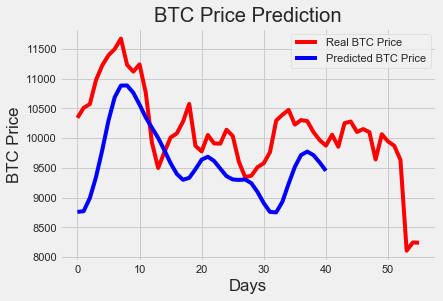

In [36]:
plot_predictions(test_set,predicted_stock_price)

In [23]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 656.2831673314847.


In [36]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-02-12,223.000000,217.300003,218.830002,221.789993,11084499,221.789993
2015-02-13,241.580002,220.619995,221.789993,236.169998,26243104,236.169998
2015-02-14,261.250000,235.380005,236.169998,258.640015,33313626,258.640015
2015-02-15,264.570007,226.559998,258.640015,233.270004,43921119,233.270004
2015-02-16,240.029999,228.009995,233.270004,235.830002,27187677,235.830002


In [16]:
df.reset_index()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-02-12,223.000000,217.300003,218.830002,221.789993,11084499,221.789993
1,2015-02-13,241.580002,220.619995,221.789993,236.169998,26243104,236.169998
2,2015-02-14,261.250000,235.380005,236.169998,258.640015,33313626,258.640015
3,2015-02-15,264.570007,226.559998,258.640015,233.270004,43921119,233.270004
4,2015-02-16,240.029999,228.009995,233.270004,235.830002,27187677,235.830002
5,2015-02-17,247.169998,232.029999,235.830002,243.199997,27926884,243.199997
6,2015-02-18,245.509995,231.699997,243.199997,235.199997,23813015,235.199997
7,2015-02-19,244.110001,234.869995,235.199997,241.919998,15852470,241.919998
8,2015-02-20,247.759995,238.830002,241.919998,244.520004,20434846,244.520004
9,2015-02-21,247.320007,242.649994,244.520004,244.410004,10570761,244.410004


Creating a rolling target window. 

In [18]:
window=11
df['Smooth'] = smooth(df['Close'].values, 2*window+1, 3)
df['Smooth'] = smooth(df['Smooth'].values, window, 1)
gc.collect()

2646

Creating a minimum and maximum list of the values. 

In [19]:
max_list = extrema(df['Smooth'].values, np.greater)[0].tolist()
min_list = extrema(df['Smooth'].values, np.less)[0].tolist()

Creating a new index

In [20]:
df['Date'] = df.index

In [21]:
df = df.dropna()

Creating our buy/sell target signal.

In [22]:
df['TARGET'] = 0

for x in min_list:
    t = df['Date'][x]
    df.loc[t, 'TARGET'] = 1
    
        
for x in max_list:
    t = df['Date'][x]
    df.loc[t, 'TARGET'] = -1
        
df['TARGET'] = df['TARGET'].replace(0, np.nan).interpolate(method='slinear').ffill().bfill()
df['TARGET'] = (df['TARGET'] >= 0.5).astype(np.uint8)

In [23]:
window=5
df['Smooth2'] = smooth(df['Close'].values, 2*window+1, 3)
df['Smooth2'] = smooth(df['Smooth'].values, window, 1)
gc.collect()

44

In [24]:
max_list2 = extrema(df['Smooth2'].values, np.greater)[0].tolist()
min_list2 = extrema(df['Smooth2'].values, np.less)[0].tolist()

In [25]:
df['TARGET2'] = 0

for x in min_list2:
    t = df['Date'][x]
    df.loc[t, 'TARGET2'] = 1
    
        
for x in max_list2:
    t = df['Date'][x]
    df.loc[t, 'TARGET2'] = -1
        
df['TARGET2'] = df['TARGET2'].replace(0, np.nan).interpolate(method='slinear').ffill().bfill()
df['TARGET2'] = (df['TARGET2'] >= 0.5).astype(np.uint8)

In [26]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,Smooth,Date,TARGET,Smooth2,TARGET2
Date,,,,,,,,,,,
2015-02-12,223.000000,217.300003,218.830002,221.789993,11084499,221.789993,235.553523,2015-02-12,0,235.553523,0
2015-02-13,241.580002,220.619995,221.789993,236.169998,26243104,236.169998,236.110316,2015-02-13,0,236.110316,0
2015-02-14,261.250000,235.380005,236.169998,258.640015,33313626,258.640015,236.667108,2015-02-14,0,236.667108,0
2015-02-15,264.570007,226.559998,258.640015,233.270004,43921119,233.270004,237.223901,2015-02-15,0,237.223901,0
2015-02-16,240.029999,228.009995,233.270004,235.830002,27187677,235.830002,237.780694,2015-02-16,0,237.801462,0


In [27]:
df.TARGET.sum()

414

In [28]:
df.TARGET2.sum()

416

In [29]:
window=17
df['Smooth3'] = smooth(df['Close'].values, 2*window+1, 3)
df['Smooth3'] = smooth(df['Smooth'].values, window, 1)
gc.collect()

73

In [30]:
max_list3 = extrema(df['Smooth3'].values, np.greater)[0].tolist()
min_list3 = extrema(df['Smooth3'].values, np.less)[0].tolist()

In [31]:
df['TARGET3'] = 0

for x in min_list2:
    t = df['Date'][x]
    df.loc[t, 'TARGET3'] = 1
    
        
for x in max_list2:
    t = df['Date'][x]
    df.loc[t, 'TARGET3'] = -1
        
df['TARGET3'] = df['TARGET3'].replace(0, np.nan).interpolate(method='slinear').ffill().bfill()
df['TARGET3'] = (df['TARGET3'] >= 0.5).astype(np.uint8)

In [32]:
df.TARGET3.sum()

416

In [43]:
window = 21
no_of_std = 2

rolling_mean = df['Smooth'].rolling(window).mean()
rolling_std = df['Smooth'].rolling(window).std()

df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

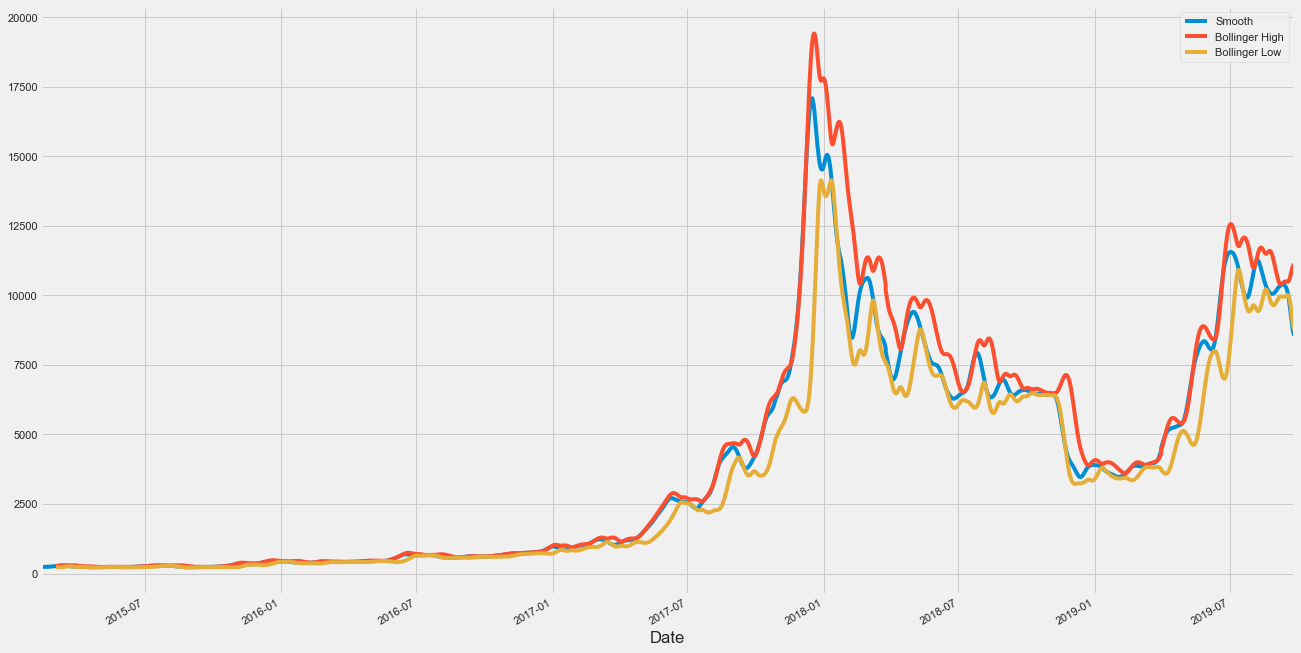

In [45]:
df[['Smooth','Bollinger High','Bollinger Low']].plot(figsize=(20,12))

In [50]:
df = df.dropna()

Removing nonessential columns.

In [22]:
del df['Adj Close']; gc.collect()

cols = ['Open', 'High', 'Low']

for col in cols:
    df['delta' + col] = df['Close'] - df[col]
    del df[col]; gc.collect()
    
df.head()

,Close,Volume,Smooth,Date,TARGET,deltaOpen,deltaHigh,deltaLow
Date,,,,,,,,
2015-02-12,221.789993,11084499,235.553523,2015-02-12,0,2.959991,-1.210007,4.489990
2015-02-13,236.169998,26243104,236.110316,2015-02-13,0,14.380005,-5.410004,15.550003
2015-02-14,258.640015,33313626,236.667108,2015-02-14,0,22.470016,-2.609985,23.260010
2015-02-15,233.270004,43921119,237.223901,2015-02-15,0,-25.370010,-31.300003,6.710007
2015-02-16,235.830002,27187677,237.780694,2015-02-16,0,2.559998,-4.199997,7.820007


In [23]:
def get_slope(y):
    x = range(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

def get_acceleration(y):
    x = range(len(y))
    acc = 0.5*np.polyfit(x, y, 2)[0]
    return acc

In [24]:
from itertools import combinations

Creating various features, including Moving Averages, Standard Deviations, Minmium and Maxmiums.

In [25]:
for i in [5, 12, 20, 50, 120, 200]:
    df['MA_{0}'.format(str(i))] = df['Close'].rolling(i).mean()
    df['MMAX_{0}'.format(str(i))] = df['Close'].rolling(i).max()
    df['MMIN_{0}'.format(str(i))] = df['Close'].rolling(i).min()
    df['MSTD_{0}'.format(str(i))] = df['Close'].rolling(i).std()
    df['MSLOPE_{0}'.format(str(i))] = df['Close'].rolling(i).apply(lambda x: get_slope(x))
    df['MACC_{0}'.format(str(i))] = df['Close'].rolling(i).apply(lambda x: get_acceleration(x))

ma_cols = [col for col in df.columns.tolist() if 'MA_' in col]
used_cols = ma_cols + ['Close']

for col1, col2 in combinations(used_cols, 2):
    # check ordering (col1 > col2)
    if col1 == 'Close':
        n1 = 1
        n2 = int(col2.split('_')[1])
    elif col2 == 'Close':
        n2 = 1
        n1 = int(col1.split('_')[1])
    else:
        n1 = int(col1.split('_')[1])
        n2 = int(col2.split('_')[1])
    # reorder (if necessary)
    if n1 < n2:
        col1, col2 = col2, col1
        
    df[col1+'_delta_'+col2] = df[col1] - df[col2]
    df[col1+'_higher_'+col2] = (df[col1+'_delta_'+col2] > 0).astype(np.uint8)

high_cols = [col for col in df.columns.tolist() if '_higher_' in col]
df['n_higher'] = df[high_cols].sum(axis=1)

max_cols = [col for col in df.columns.tolist() if 'MMAX_' in col]

for col in max_cols:
    df['delta_'+col] = df['Close'] - df[col]
    df['higher_'+col] = (df['delta_'+col] > 0).astype(np.uint8)

for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    df['lag_{0}'.format(str(i))] = df['Close'].shift(i)
    df['pct_{0}'.format(str(i))] = df['lag_{0}'.format(str(i))] / df['Close']

More Features...

In [26]:
for i in [1, 3, 5, 10, 20, 30]:
        df['MAVS_{0}'.format(str(i))] = df['Volume'].rolling(i).sum()

In [27]:
for i in [1, 2, 3, 4, 5, 6, 7, 8]:
        df['MAV_{0}'.format(str(i))] = df['Volume'].rolling(i).mean()
        df['lagV_{0}'.format(str(i))] = df['MAV_{0}'.format(str(i))].shift(i)
        df['MRMAX_{0}'.format(str(i))] = df['Close'].rolling(i).max()
        df['MRMIN_{0}'.format(str(i))] = df['Close'].rolling(i).min()
        df['MRMAXL_{0}'.format(str(i))] = df['MRMAX_{0}'.format(str(i))].shift(i)
        df['MRMINL_{0}'.format(str(i))] = df['MRMIN_{0}'.format(str(i))].shift(i)

Creating a makeshift Relative Strength Index

In [31]:
df['RSI'] = 100*(df['n_higher']/28)

In [32]:
df['dow'] = df['Date'].dt.dayofweek
df['week'] = df['Date'].dt.week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

Increasing window of display so we can view all the various features. 

In [33]:
pd.set_option('display.max_columns', 185)

Removing any nan's in the data.


In [34]:
df = df.dropna()

In [62]:
df.head()

,Close,Volume,Smooth,Date,TARGET,deltaOpen,deltaHigh,deltaLow,MA_5,MMAX_5,MMIN_5,MSTD_5,MSLOPE_5,MACC_5,MA_12,MMAX_12,MMIN_12,MSTD_12,MSLOPE_12,MACC_12,MA_20,MMAX_20,MMIN_20,MSTD_20,MSLOPE_20,MACC_20,MA_50,MMAX_50,MMIN_50,MSTD_50,MSLOPE_50,MACC_50,MA_120,MMAX_120,MMIN_120,MSTD_120,MSLOPE_120,MACC_120,MA_200,MMAX_200,MMIN_200,MSTD_200,MSLOPE_200,MACC_200,MA_12_delta_MA_5,MA_12_higher_MA_5,MA_20_delta_MA_5,MA_20_higher_MA_5,MA_50_delta_MA_5,MA_50_higher_MA_5,MA_120_delta_MA_5,MA_120_higher_MA_5,MA_200_delta_MA_5,MA_200_higher_MA_5,MA_5_delta_Close,MA_5_higher_Close,MA_20_delta_MA_12,MA_20_higher_MA_12,MA_50_delta_MA_12,MA_50_higher_MA_12,MA_120_delta_MA_12,MA_120_higher_MA_12,MA_200_delta_MA_12,MA_200_higher_MA_12,MA_12_delta_Close,MA_12_higher_Close,MA_50_delta_MA_20,MA_50_higher_MA_20,MA_120_delta_MA_20,MA_120_higher_MA_20,MA_200_delta_MA_20,MA_200_higher_MA_20,MA_20_delta_Close,MA_20_higher_Close,MA_120_delta_MA_50,MA_120_higher_MA_50,MA_200_delta_MA_50,MA_200_higher_MA_50,MA_50_delta_Close,MA_50_higher_Close,MA_200_delta_MA_120,MA_200_higher_MA_120,MA_120_delta_Close,MA_120_higher_Close,MA_200_delta_Close,MA_200_higher_Close,n_higher,delta_MMAX_5,higher_MMAX_5,delta_MMAX_12,higher_MMAX_12,delta_MMAX_20,higher_MMAX_20,delta_MMAX_50,higher_MMAX_50,delta_MMAX_120,higher_MMAX_120,delta_MMAX_200,higher_MMAX_200,lag_1,pct_1,lag_2,pct_2,lag_3,pct_3,lag_4,pct_4,lag_5,pct_5,lag_6,pct_6,lag_7,pct_7,lag_8,pct_8,lag_9,pct_9,lag_10,pct_10,lag_11,pct_11,lag_12,pct_12,MAVS_1,MAVS_3,MAVS_5,MAVS_10,MAVS_20,MAVS_30,MAV_1,MAV_2,MAV_3,MAV_4,MAV_5,MAV_6,MAV_7,MAV_8,lagV_1,lagV_2,lagV_3,lagV_4,lagV_5,lagV_6,lagV_7,lagV_8,MRMAX_1,MRMIN_1,MRMAX_2,MRMIN_2,MRMAX_3,MRMIN_3,MRMAX_4,MRMIN_4,MRMAX_5,MRMIN_5,MRMAX_6,MRMIN_6,MRMAX_7,MRMIN_7,MRMAX_8,MRMIN_8,MRMAXL_1,MRMINL_1,MRMAXL_2,MRMINL_2,MRMAXL_3,MRMINL_3,MRMAXL_4,MRMINL_4,MRMAXL_5,MRMINL_5,MRMAXL_6,MRMINL_6,MRMAXL_7,MRMINL_7,MRMAXL_8,MRMINL_8,RSI,dow,week,month,year,TRAIN,TEST
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-29,228.399994,9118089,227.220950,2015-08-29,1,-0.100006,-3.920013,2.959991,227.247998,231.639999,222.729996,3.456367,1.262999,-0.277500,226.460831,234.660004,211.429993,6.212158,-0.226119,0.140943,240.208998,269.029999,211.429993,18.438870,-2.704151,0.104141,264.986797,310.440002,211.429993,24.707603,-1.471966,-0.021151,251.786583,310.440002,211.429993,22.207845,0.258095,-0.004688,250.74745,310.440002,211.429993,21.581214,0.050474,0.000837,-0.787167,0,12.961000,1,37.738799,1,24.538585,1,23.499452,1,-1.151996,0,13.748167,1,38.525967,1,25.325752,1,24.286619,1,-1.939163,0,24.777799,1,11.577584,1,10.538452,1,11.809004,1,-13.200215,0,-14.239348,0,36.586804,1,-1.039133,0,23.386589,1,22.347456,1,15,-3.240005,0,-6.260010,0,-40.630005,0,-82.040009,0,-82.040009,0,-82.040009,0,228.500000,1.000438,231.639999,1.014186,222.729996,0.975175,224.970001,0.984983,220.509995,0.965455,211.429993,0.925701,226.750000,0.992776,229.539993,1.004991,232.399994,1.017513,234.660004,1.027408,226.000000,0.989492,246.720001,1.080210,9118089.0,39941710.0,74559107.0,199886167.0,398859966.0,528075694.0,9118089.0,9595145.0,1.331390e+07,13393205.25,14911821.4,1.920181e+07,2.260278e+07,2.117794e+07,10072201.0,17191265.5,2.508972e+07,28962673.75,25065412.0,2.690251e+07,2.209723e+07,2.145753e+07,228.399994,228.399994,228.500000,228.399994,231.639999,228.399994,231.639999,222.729996,231.639999,222.729996,231.639999,220.509995,231.639999,211.429993,231.639999,211.429993,228.500000,228.500000,231.639999,222.729996,224.970001,220.509995,226.750000,211.429993,232.399994,211.429993,234.660004,211.429993,257.130005,226.000000,260.519989,226.000000,53.571429,5,35,8,2015,0,0
2015-08-30,229.470001,12521966,228.228212,2015-08-30,0,1.070007,-2.319992,5.270004,228.147998,231.639999,222.729996,3.297117,1.024001,-0.451429,226.749997,234.660004,211.429993,6.269256,-0.131329,0.191074,238.230

PCA

Creating a train and test dataset 

In [36]:
df = df.dropna(); gc.collect()

start_train = '2015-09-01'
end_train = '2019-01-01'

start_test = '2019-01-01'
end_test = '2019-08-18'

df['TRAIN'] = 0
df['TEST'] = 0

df.loc[(df['Date'] >= start_train) & (df['Date'] < end_train), 'TRAIN'] = 1
df.loc[(df['Date'] >= start_test) & (df['Date'] < end_test), 'TEST'] = 1

In [37]:
train = df[df['TRAIN'] == 1]
test = df[df['TEST'] == 1]

Removing useless columns before running it through weight of evidence encoder. 

In [38]:
used_cols = [col for col in df.columns.tolist() if not col in ['n_higher','TARGET', 'Date', 'TRAIN', 'TEST', 'visTARGET']]

In [39]:
X_train = train[used_cols]
y_train = (train.TARGET ==1).astype(np.uint8)

X_test = test[used_cols]
y_test = (test.TARGET ==1 ).astype(np.uint8)

gc.collect()

73

Weight of Evidence to locate the most important features.

In [40]:
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string


max_bin = 20
force_bin = 2


# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    df2 = df1.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.groups
    d3["MAX_VALUE"] = df2.groups
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y     
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    
    iv['STRENGTH'] = 'useless'
    iv.loc[iv['IV'] >= 0.02, 'STRENGTH'] = 'weak'
    iv.loc[iv['IV'] >= 0.1, 'STRENGTH'] = 'medium'
    iv.loc[iv['IV'] >= 0.3, 'STRENGTH'] = 'strong'
    iv.loc[iv['IV'] > 0.5, 'STRENGTH'] = 'suspicious'
    
    iv = iv.reset_index()
    
    return(iv_df,iv)

In [41]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.externals import joblib 


class BaseTransformer(BaseEstimator, TransformerMixin):
    """
    Base class.
    """
    def __init__(self, columns=None, suffix='_base'):
        self.columns = columns
        self.suffix = suffix
        self.scaler = None
    
    def fit(self, X, y=None, **fit_params):
        if self.columns is None:
            self.columns = X.columns.tolist()
        self.scaler.fit(X[self.columns])
    
    def transform(self, X, y=None, **transform_params):
        return None
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def save(self, path):
        joblib.dump((self.columns, self.suffix, self.scaler), path)
    
    def load(self, path):
        self.columns, self.suffix, self.scaler = joblib.load(path)

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
from category_encoders import TargetEncoder as Tar
from sklearn.externals import joblib

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import gc; gc.enable()



class WoeEncoder(BaseTransformer):
    """
    Weight of Evidence Encoding.
    """
    def __init__(self, columns=None, suffix="_woe"):
        self.columns = columns
        self.suffix = suffix
        self.iv_df = pd.DataFrame()
        
    def fit(self, df, y=None):
        # bandaid
        df = pd.DataFrame(df)
        df.columns = [str(col) for col in df.columns.tolist()]
        
        if self.columns is None:
            self.columns = df.columns.tolist()
        
        iv_df, iv = data_vars(df[self.columns], y)
        
        self.iv_df = iv_df
    
    def transform(self, df, y=None):
        # bandaid
        df = pd.DataFrame(df)
        df.columns = [str(col) for col in df.columns.tolist()]
        
        for col in self.columns:
            LBs = self.iv_df[self.iv_df['VAR_NAME'] == col]['MIN_VALUE'].tolist()
            UBs = self.iv_df[self.iv_df['VAR_NAME'] == col]['MAX_VALUE'].tolist()
            if is_numeric_dtype(df[col]):
                criteria = [df[col].between(LBs[i], UBs[i]) for i in range(len(LBs))]
            else:
                criteria = [df[col].isin([LBs[i]]) for i in range(len(LBs))]
                
            values = self.iv_df[self.iv_df['VAR_NAME'] == col]['WOE'].tolist()
            default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
#             default = 0

            df[col + self.suffix] = np.select(criteria, values, default)

            del LBs; del UBs; del criteria; del values; del default; gc.collect()
            
        return df
    
    def fit_transform(self, df, y=None):
        self.fit(df, y)
        return self.transform(df, y)

In [43]:
iv_df, iv = data_vars(X_train, y_train)

Removing features of low importance.

In [44]:
used_cols = iv[iv.IV >= 0.10]['VAR_NAME'].tolist()

In [45]:
X_train = train[used_cols]
y_train = (train.TARGET == 1).astype(np.uint8)

X_test = test[used_cols]
y_test = (test.TARGET == 1).astype(np.uint8)

gc.collect()

1046

In [46]:
woe = WoeEncoder(suffix='')

X_train = woe.fit_transform(X_train, y_train).fillna(0)
X_test = woe.transform(X_test).fillna(0)

In [47]:
RANDOM_SEED = 42

In [48]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np

clf0 = LogisticRegression(class_weight='balanced', n_jobs=-1)
clf1 = MLPClassifier()
clf2 = RandomForestClassifier(random_state=1, class_weight='balanced', n_jobs=-1)
clf3 = GaussianNB()
lr = LogisticRegression(class_weight='balanced', n_jobs=-1)

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf0, clf1, clf2, clf3],
                            use_probas=True,
                            meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf0, clf1, clf2, clf3, sclf], 
                      ['Logistic Regression',
                       'Perceptron', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train.values, y_train.values, 
                                              cv=3, scoring='roc_auc')
    print("AUC: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    
    scores = model_selection.cross_val_score(clf, X_train.values, y_train.values, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    print()

3-fold cross validation:

AUC: 0.81 (+/- 0.05) [Logistic Regression]
Accuracy: 0.68 (+/- 0.10) [Logistic Regression]

AUC: 0.74 (+/- 0.04) [Perceptron]
Accuracy: 0.69 (+/- 0.04) [Perceptron]

AUC: 0.67 (+/- 0.06) [Random Forest]
Accuracy: 0.64 (+/- 0.08) [Random Forest]

AUC: 0.82 (+/- 0.02) [Naive Bayes]
Accuracy: 0.68 (+/- 0.12) [Naive Bayes]

AUC: 0.75 (+/- 0.06) [StackingClassifier]
Accuracy: 0.64 (+/- 0.10) [StackingClassifier]



In [49]:
sclf.fit(X_train.values, y_train.values)

StackingCVClassifier(classifiers=[LogisticRegression(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='warn',
                                                     n_jobs=-1, penalty='l2',
                                                     random_state=None,
                                                     solver='warn', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                                  MLPClassifier(activation='relu', alpha=0.0

In [50]:
y_pred = sclf.predict(X_test.values)

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import adjusted_rand_score as info_score

In [52]:
print(precision_score(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
print(mcc(y_test, y_pred))
print()
print(info_score(y_test, y_pred))

0.4423076923076923

[[146  29]
 [ 32  23]]

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       175
           1       0.44      0.42      0.43        55

    accuracy                           0.73       230
   macro avg       0.63      0.63      0.63       230
weighted avg       0.73      0.73      0.73       230


0.2574507916110083

0.14908369416272937


In [53]:
from sklearn.model_selection import GridSearchCV

# Initializing models
clf0 = LogisticRegression(class_weight='balanced', n_jobs=-1)
clf1 = KNeighborsClassifier(n_neighbors=1, weights='distance', n_jobs=-1)
clf2 = RandomForestClassifier(random_state=1, class_weight='balanced', n_jobs=-1)
clf3 = GaussianNB()
lr = LogisticRegression(class_weight='balanced', n_jobs=-1)

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf0, clf1, clf2, clf3], 
                            meta_classifier=lr)


params = {'logisticregression__C': [0.1, 10.0],
          'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}
# five fold cross-validation
grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5, 
                    refit=True)
grid.fit(X_train.values, y_train.values)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print()
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.712 +/- 0.04 {'kneighborsclassifier__n_neighbors': 1, 'logisticregression__C': 0.1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.694 +/- 0.04 {'kneighborsclassifier__n_neighbors': 1, 'logisticregression__C': 0.1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.711 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'logisticregression__C': 0.1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.692 +/- 0.04 {'kneighborsclassifier__n_neighbors': 1, 'logisticregression__C': 0.1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.698 +/- 0.04 {'kneighborsclassifier__n_neighbors': 1, 'logisticregression__C': 10.0, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.699 +/- 0.04 {'kneighborsclassifier__n_neighbors': 1, 'logisticregression__C': 10.0, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.715 +/- 0.05 {'kneighborsclassifier__n_neighbors': 1

In [57]:
from sklearn import model_selection
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np

clf0 = LogisticRegression(class_weight='balanced', n_jobs=-1)
clf1 = MLPClassifier()
# clf2 = RandomForestClassifier(random_state=1, class_weight='balanced', n_jobs=-1)
clf3 = GaussianNB()
clf4 = xgb.XGBClassifier(silent=False, scale_pos_weight=1, learning_rate=0.001, colsample_bytree = 0.4, subsample = 0.8, objective='binary:logistic', n_estimators = 1000, reg_alpha = 0.3, max_depth=5, gamma=10)
lr = LogisticRegression(class_weight='balanced', n_jobs=-1)

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf0, clf1, clf3, clf4],
                            use_probas=True,
                            meta_classifier=clf3)

print('3-fold cross validation:\n')

for clf, label in zip([clf0, clf1, clf3, clf4, sclf], 
                      ['Logistic Regression',
                       'Perceptron', 
                     
                       'Naive Bayes',
                       'Xgboost', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train.values, y_train.values, 
                                              cv=3, scoring='roc_auc')
    print("AUC: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    
    scores = model_selection.cross_val_score(clf, X_train.values, y_train.values, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    print()

3-fold cross validation:

AUC: 0.81 (+/- 0.05) [Logistic Regression]
Accuracy: 0.68 (+/- 0.10) [Logistic Regression]

AUC: 0.74 (+/- 0.04) [Perceptron]
Accuracy: 0.69 (+/- 0.04) [Perceptron]

AUC: 0.82 (+/- 0.02) [Naive Bayes]
Accuracy: 0.68 (+/- 0.12) [Naive Bayes]

AUC: 0.77 (+/- 0.04) [Xgboost]
Accuracy: 0.64 (+/- 0.09) [Xgboost]

AUC: 0.80 (+/- 0.06) [StackingClassifier]
Accuracy: 0.67 (+/- 0.10) [StackingClassifier]

